In [1]:
import pyrosetta
import dask.bag
import dask.distributed

In [2]:
import pandas
import seaborn
from matplotlib import pylab

In [3]:
from pyrosetta.distributed.tasks.score import ScorePoseTask
from pyrosetta.distributed.io import pose_from_pdbstring
from pyrosetta.distributed.packed_pose import to_dict

In [4]:
import zipfile

In [5]:
import py3Dmol

# Init

Setup LocalCluster to full utilize the current machine.

In [6]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)
client

<Client: scheduler='tcp://127.0.0.1:38929' processes=8 cores=48>

# Load 

Load decoys from batch compute run, adding annotations for designed sequence, cystine count and cystine location.

In [7]:
def load_source(decoy):
    src_pdb = zipfile.ZipFile(library).open(decoy).read()
    p = pose_from_pdbstring(src_pdb)
    
    cys_locations=[i for i, c in enumerate(p.pose.sequence()) if c == "C"]
    p = p.update_scores(
        library=library,
        decoy=decoy,
        sequence=p.pose.sequence(),
        num_res = len(p.pose.sequence()),
        num_cys=len(cys_locations),
        cys_locations=",".join(map(str, cys_locations))
    )

    return p

In [8]:
library = "EHEE_library.zip"
decoy_names = [f.filename for f in zipfile.ZipFile(library).filelist if f.filename.endswith(".pdb")]

In [9]:
decoys = dask.bag.from_sequence(decoy_names).map(load_source).map(ScorePoseTask()).persist()

In [10]:
result_frame = pandas.DataFrame.from_records(decoys.map(to_dict).compute()).sort_values("total_score")

# Analysis

We anticipate a distribution of score results, with higher scores with more disulfide insertions.

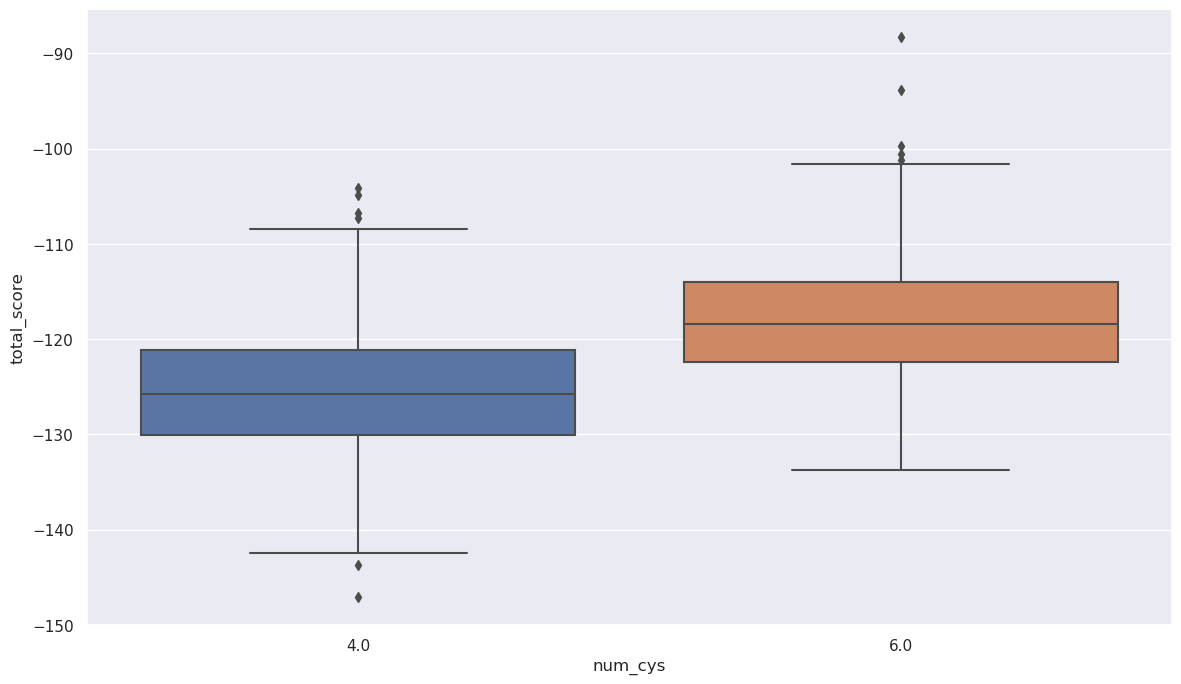

In [11]:
seaborn.boxplot(x="num_cys", y="total_score", data=result_frame)

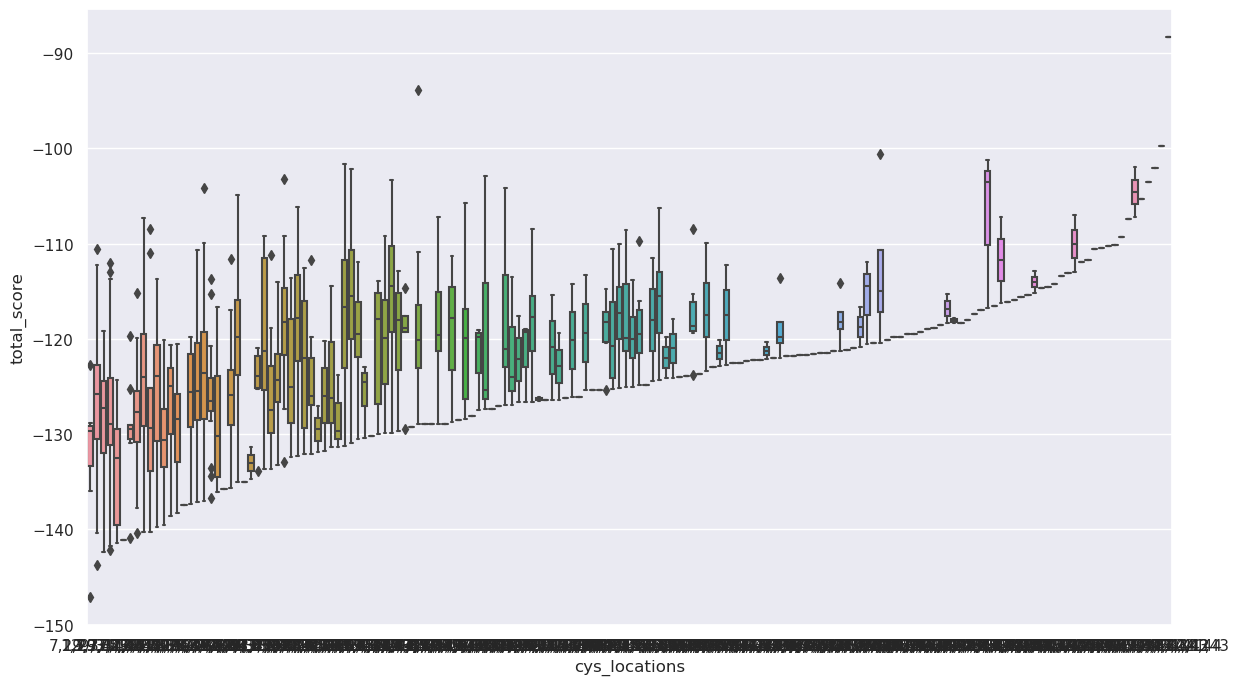

In [12]:
seaborn.boxplot(x="cys_locations", y="total_score", data=result_frame)

# Select 

Select the best model by total_Score for each inserted disulfide location, allowing us to test a variety of disulfide architectures.

In [13]:
best_by_location = to_dict(result_frame.groupby("cys_locations").head(1).reset_index(drop=True))

In [14]:
with open("EHEE.best_by_location.fasta", "w") as out:
    for entry in best_by_location:
        print(f">{entry['decoy']}", file=out)
        print(entry['sequence'], file=out)

In [15]:
!head EHEE.best_by_location.fasta

>30652025_EHEE_254_0001.pdb
GDYQLHTCNTSEEELKKLTETLRRRLQTECKLERHGDCYTITCHV
>30887334_EHEE_738_0001.pdb
GCKTLTFCGYDDEQAKKIQKDISKTVQRPVEVHKHGSCWEFHVCV
>30856927_EHEE_395_0001.pdb
GCTTWEFHNVDPNEVKKALRELSEKTGAECHLEQHGNTFHITCCV
>30884953_EHEE_269_0001_0004.pdb
GQKCVTFCGQDPREVKKIAEEIARRLQVPYEIRRHGSCITVCFKV
>30696637_EHEE_467_0001_0002.pdb
GTKTFTYDGVDPTEVDKSRERLEKELKTRCELECRGNQCHIHCHV


In [16]:
len(best_by_location)

162

# Visualize 
Spot check a collection of design model, highlighting inserted cystine locations.

In [17]:
view = py3Dmol.view(viewergrid=(3, 3), linked=False, width=900, height=900)
for i in range(9):
    view.addModel( pyrosetta.distributed.io.to_pdbstring(best_by_location[i]), "pdb", viewer=(i/3, i%3),)
    
view.setStyle({'cartoon':{'color':'spectrum'}})
view.setStyle({"resn": "CYS"}, {'stick': {}, 'cartoon':{'color':'spectrum'}} )
view.zoomTo()

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2019.22+release.d8f9b4a90a8f2caa32948bacdb6e551591facd5f 2019-05-30T13:47:16] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol